# Motor Closed loop position control lab

This Jupyter notebook, with the python control toolbox can be used as a template for your modeling, controller design and closed loop verification before you start building hardware!

Change values and the cell and re-run the cells to see what happens as you change certain things. 

-- Brij, <br>
www.mechatronics-school.com <br>
Jul-09-2019, Cambridge, MA, USA

Bugs, feedback, comments? *Email:* school.mechatronics@gmail.com

## Block Diagram
![Block diagram of the Motor setup](MotorLab_BlockDiagram.svg "Block-diagram - Motor Control Lab")


# Initialization

In [1]:
# import all libraries
# %matplotlib widget
# %matplotlib notebook #uncomment this if you want interactivity in plotting
from control import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
s=tf([1,0],[1]); # Define the s variable for later use - this allows us to define transfer functions more easily

# Measured bode plot - deg/V

In [3]:
# Collect the measured data and assign varaibles to measured freq, mag, phase values
freq = np.asarray([0.5,0.33, 1, 10, 20]) #In Hz
mag = np.asarray([22.67, 34.75, 9.17, 0.49, 0.10]) #mag in deg/V
phase = np.asarray([-90, -90, -90, -180, -180]) #phase in deg

In [4]:
ω = freq*2*np.pi #Convert freq to rad/s

Text(0, 0.5, 'phase[deg]')

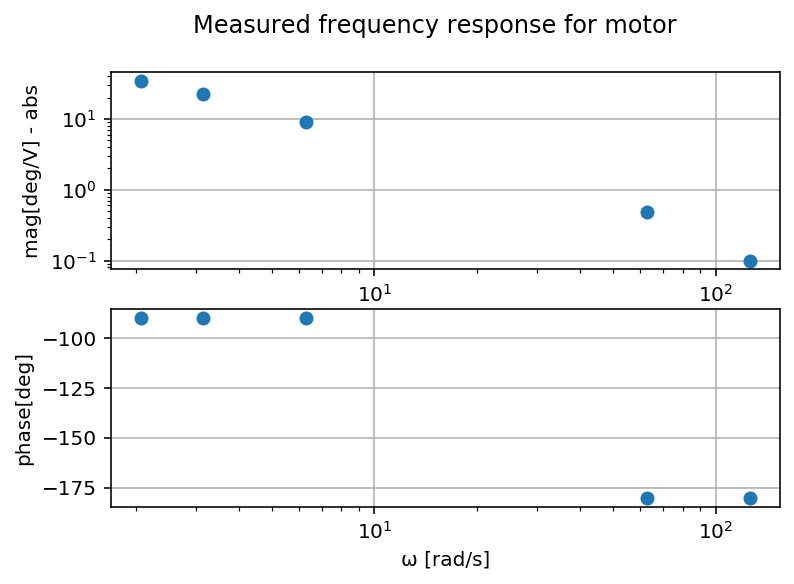

In [5]:
#Plot Measured Bode plot
plt.close(1)
plt.figure(1)
plt.suptitle('Measured frequency response for motor')
plt.subplot(2,1,1)
plt.grid()
plt.loglog(freq*2*np.pi, mag, 'o');
plt.ylabel('mag[deg/V] - abs')
plt.subplot(2,1,2)
plt.grid()
plt.semilogx(freq*2*np.pi, phase, 'o')
plt.xlabel('ω [rad/s]')
plt.ylabel('phase[deg]')
# plt.savefig('BodePlot.pdf')

# Modeling

In [6]:
Kt = 1; #[Nm/A] Measured by rotated at known speed and measuring the back-emf
J = 0.02; #[Nms^2/rad]m -- fitted value based on measured bode plot
L = 0.005; #[H] measured by LCR meter
R = 5; #[Ω] measured by LCR meter
b = 0.2; #[Nms/rad] -- fitted value based on measured bode plot

In [7]:
#Plant model transfer function
amp_scaling = 12/255; #scaling factor +255 in arduino code gives 12 V input to motor, -255 in arduino code gives -12V
plant = amp_scaling * ((180/np.pi)*Kt/(s*(J*L*(s**2) + (J*R + b*L)*s + (b*R + Kt**2)))); # [deg/Vcmd] Remember to convert from rad to deg
plant


            2.696
----------------------------
0.0001 s^3 + 0.101 s^2 + 2 s

(array([-989.79377059,  -20.20622941,    0.        ]),
 array([], dtype=float64))

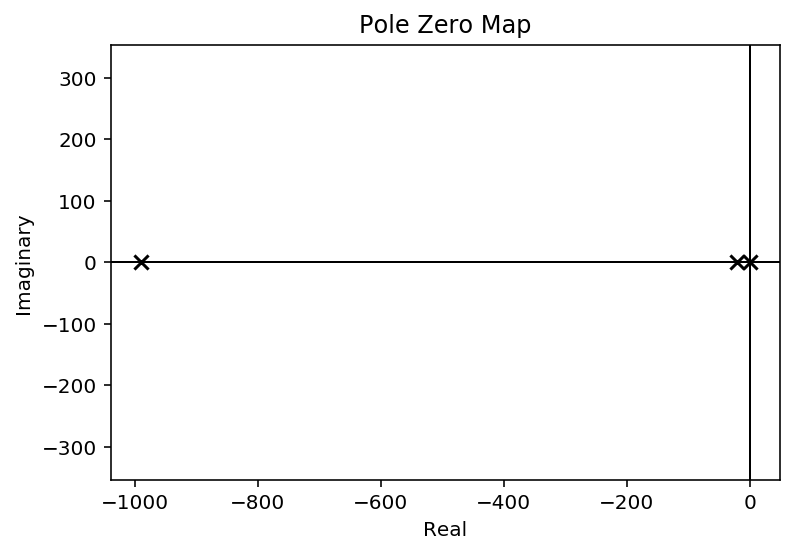

In [8]:
pzmap(plant)

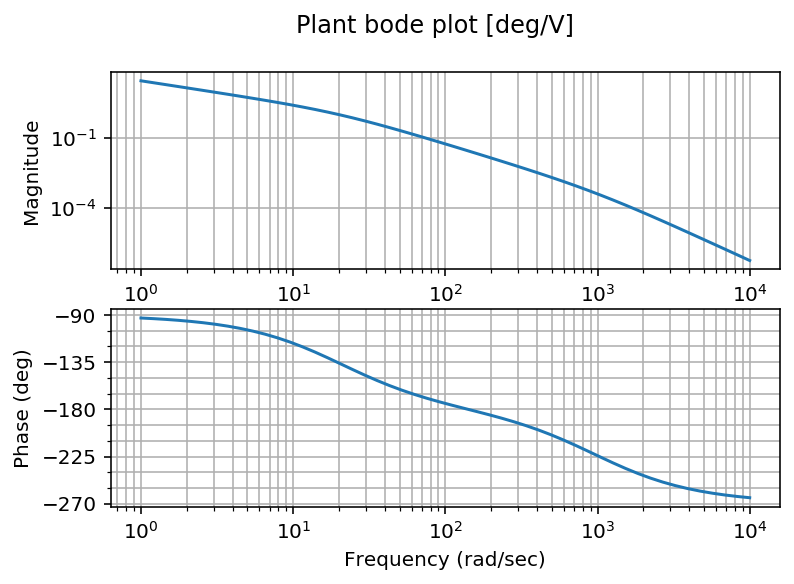

In [9]:
m, p, ω = bode_plot(plant/amp_scaling); # Units: [deg/V]:  mag [abs], phase [rad], ω [rad/s] - compare with measured bode plot
p = p*180/np.pi; 
plt.suptitle('Plant bode plot [deg/V]');

Text(0, 0.5, 'phase[deg]')

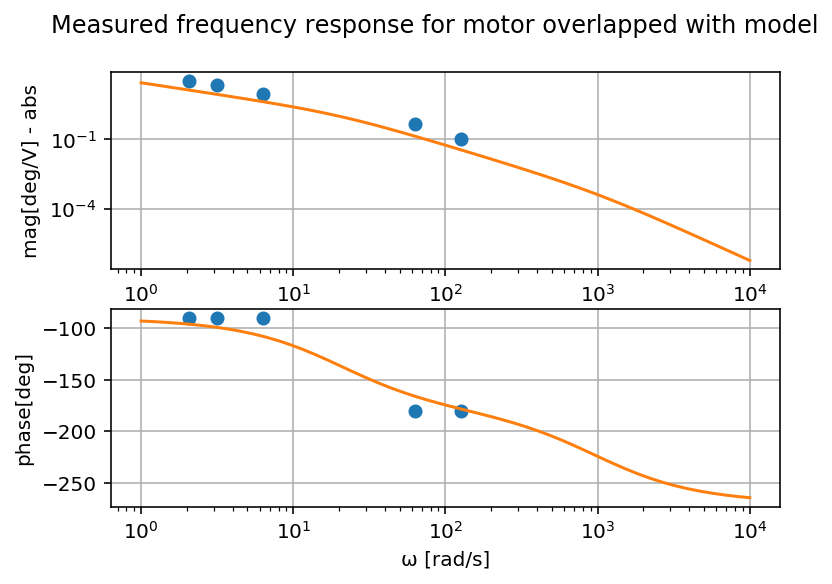

In [10]:
# Plot Bode plot of measured vs. model
plt.close(1)
plt.figure(1)
plt.suptitle('Measured frequency response for motor overlapped with model')
plt.subplot(2,1,1)
plt.grid()
plt.loglog(freq*2*np.pi, mag, 'o');
plt.loglog(ω,m);
plt.ylabel('mag[deg/V] - abs')
plt.subplot(2,1,2)
plt.grid()
plt.semilogx(freq*2*np.pi, phase, 'o')
plt.semilogx(ω,p)
plt.xlabel('ω [rad/s]')
plt.ylabel('phase[deg]')
# plt.savefig('BodePlot_overlap.pdf')

# Design controller

In [11]:
ω_c = 100; #[rad/s] crossover frequency
ϕ_m = 60; #[deg] phase margin

In [12]:
#Find current phase angle [deg]
ϕ_plant = np.angle(evalfr(plant,1j*ω_c),deg=True); #[deg] plant phase at crossover frequency
ϕ_boost = -180 - ϕ_plant + ϕ_m #[deg] amount of phase to be added in degrees
# evalfr(plant,1j*ω_c)
print("ϕ_plant at ω_c of {:d} rad/s is: {:.2f} deg".format(ω_c,ϕ_plant));
print("ϕ_boost required at ω_c of {:d} rad/s for ϕ_margin of {:.2f} deg is: {:.2f} deg".format(ω_c,ϕ_m,ϕ_boost));

ϕ_plant at ω_c of 100 rad/s is: -174.35 deg
ϕ_boost required at ω_c of 100 rad/s for ϕ_margin of 60.00 deg is: 54.35 deg


In [13]:
α = (1 + np.sin(np.deg2rad(ϕ_boost)))/(1 - np.sin(np.deg2rad(ϕ_boost)))
τ = 1/(np.sqrt(α)*ω_c)
print("α = {:.2f}".format(α))
print("τ = {:.4f}".format(τ))

α = 9.67
τ = 0.0032


In [14]:
C_lead = (α*τ*s + 1)/(τ*s + 1) #Build the lead compensator
C_lead


 0.0311 s + 1
--------------
0.003216 s + 1

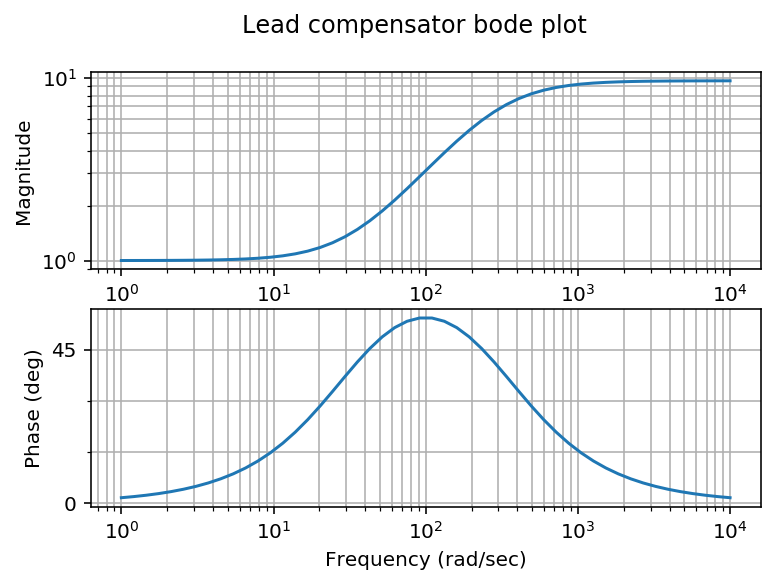

In [15]:
bode_plot(C_lead);
plt.suptitle('Lead compensator bode plot');

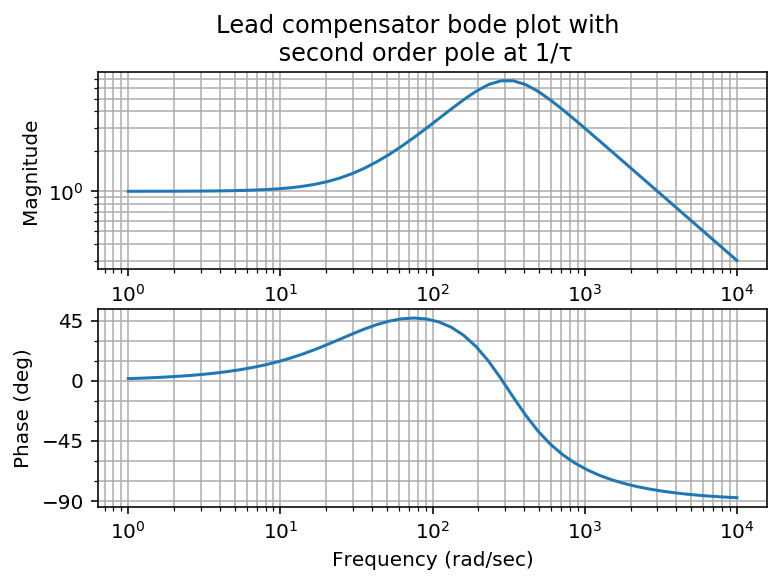

In [37]:
# # More advanced, lead with a low pass filter
# # Derivative action starts at 1/(α*τ) and at 1/τ add a second order low-pass filter with low dampiing for sharp frequency response
# ω_lpf = 1/τ;
# ζ_lpf = np.sqrt(2)/2
# C_lead = (α*τ*s + 1)/((s/ω_lpf)**2 + 2*(ζ_lpf)/(ω_lpf)*s + 1)
# bode_plot(C_lead);
# plt.suptitle('Lead compensator bode plot with \n second order pole at 1/τ');

In [16]:
Ki = ω_c/10; #zero from integrator at-least one decade before crossover freq.
C_lag = (1 + Ki/s) #Build the lag compensator
print("Ki = {:.2f}".format(Ki))

Ki = 10.00


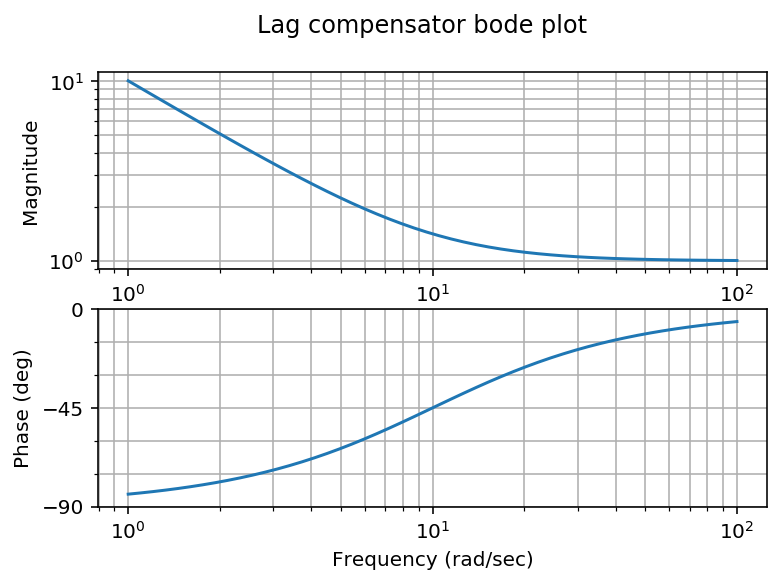

In [17]:
bode_plot(C_lag);
plt.suptitle('Lag compensator bode plot');

In [18]:
Kp = 1/abs(evalfr(plant*C_lead*C_lag,1j*ω_c)) #Find value of Kp
print("Kp = {:.2f}".format(Kp))

Kp = 120.45


In [19]:
ctrl = Kp*C_lead*C_lag
ctrl


3.746 s^2 + 157.9 s + 1205
--------------------------
     0.003216 s^2 + s

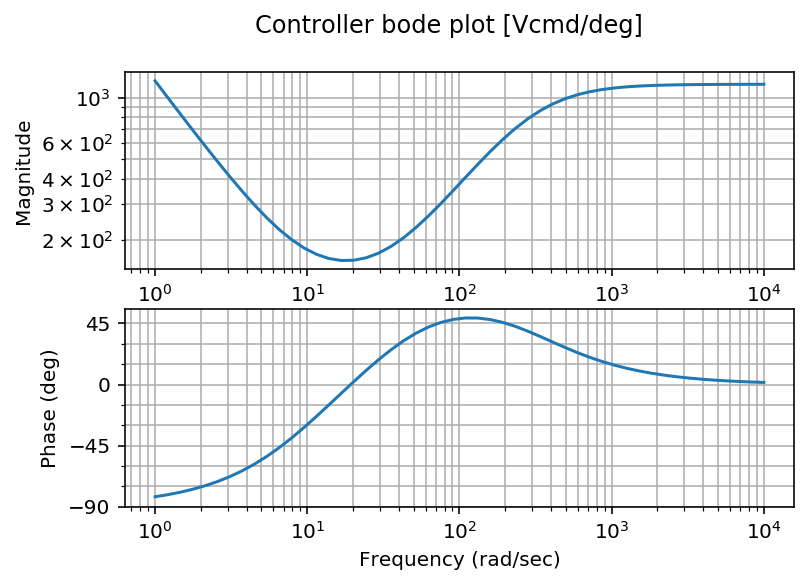

In [20]:
# Controller transfer function - input degrees and output Voltage
bode_plot(ctrl);
plt.suptitle('Controller bode plot [Vcmd/deg]');

/Users/brij/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/brij/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


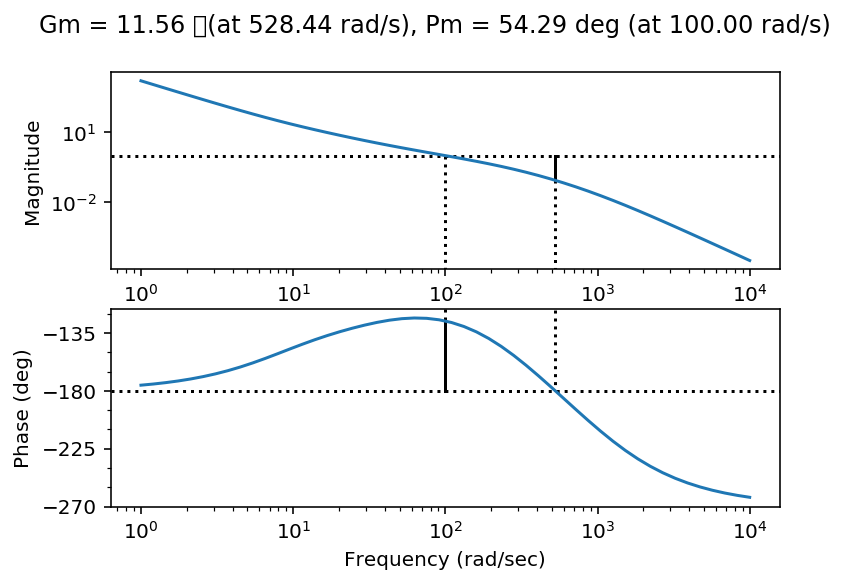

In [21]:
# Return ratio bode plot. Find out what the gain and phase margins are
RR = ctrl*plant
bode_plot(RR, margins=True);

# Verify closed loop performance

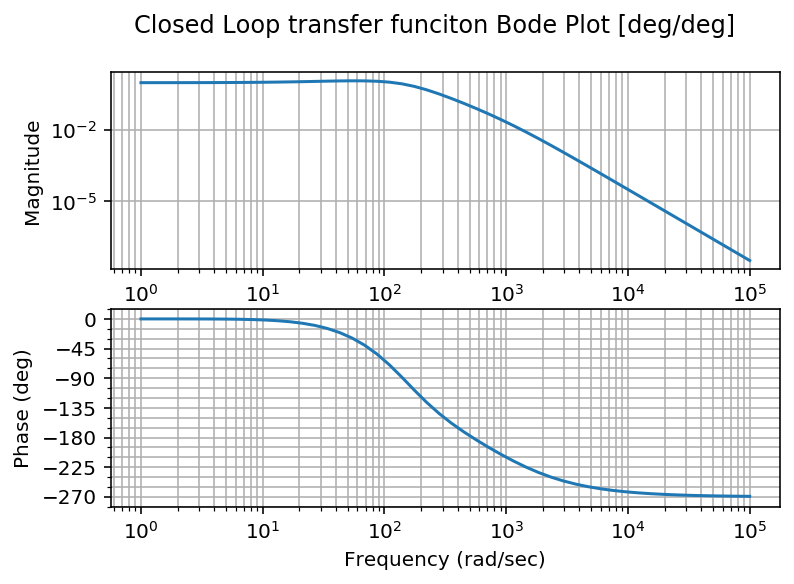

In [22]:
CL = feedback(RR,1)
bode_plot(CL);
plt.suptitle('Closed Loop transfer funciton Bode Plot [deg/deg]');

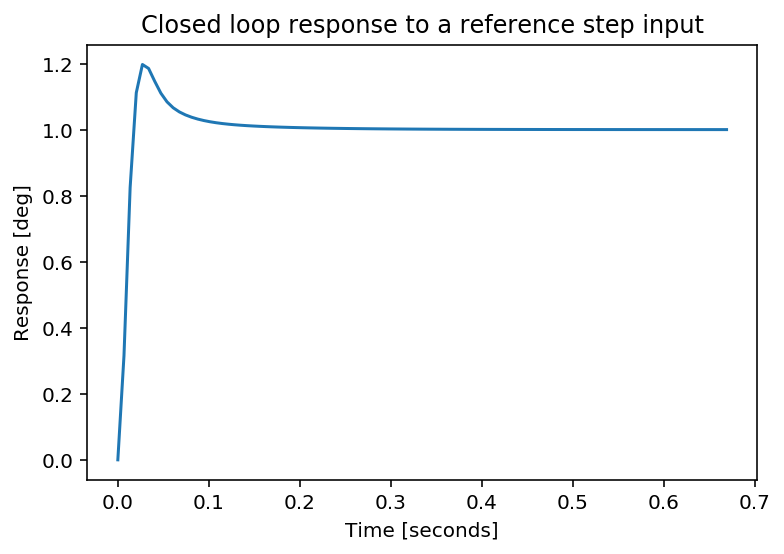

In [23]:
t,y = step_response(CL)
plt.plot(t,y);
plt.title('Closed loop response to a reference step input')
plt.xlabel('Time [seconds]')
plt.ylabel('Response [deg]');

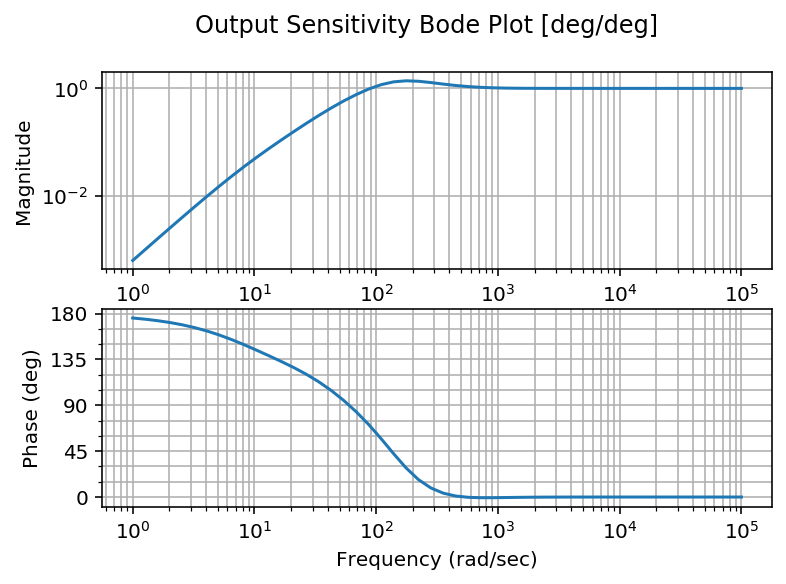

In [24]:
S = feedback(1,RR)
bode(S);
plt.suptitle('Output Sensitivity Bode Plot [deg/deg]');

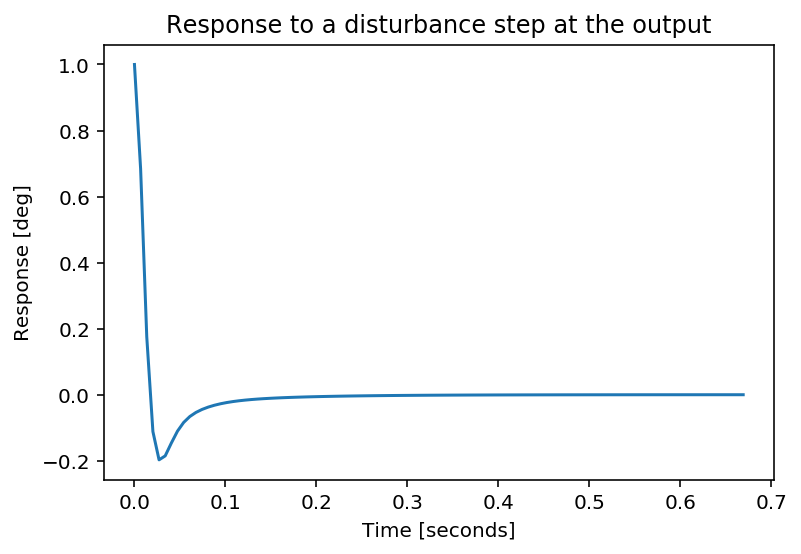

In [25]:
#Step response to disturbance
t,y = step_response(S)
plt.plot(t,y)
plt.title('Response to a disturbance step at the output')
plt.ylabel('Response [deg]')
plt.xlabel('Time [seconds]');

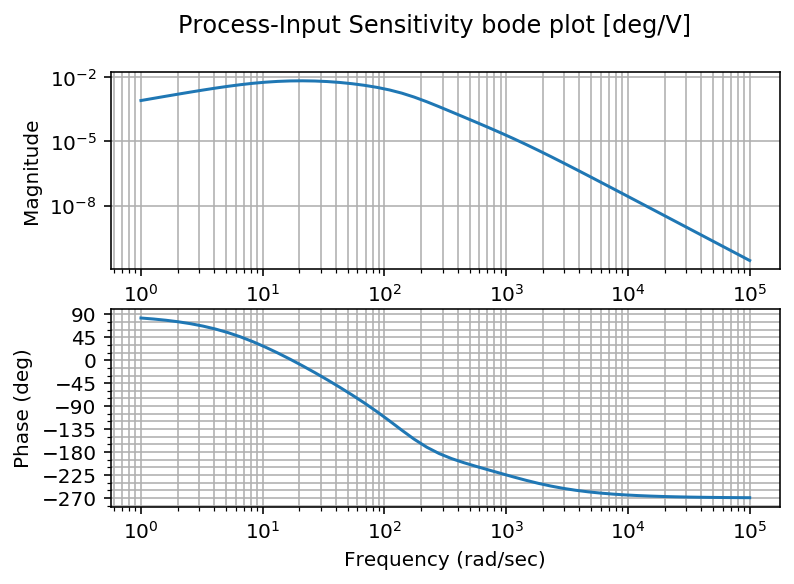

In [26]:
#Transfer funciton from Control Voltage to closed-loop output (Process Disturbance transfer function)
PS = feedback(plant,ctrl); # similar as MATLAB feedback command: Refer to documentation for MATLAB https://www.mathworks.com/help/control/ref/feedback.html;jsessionid=52a35251e753ce0cdc3febb70ffe
bode(PS);
plt.suptitle('Process-Input Sensitivity bode plot [deg/V]');

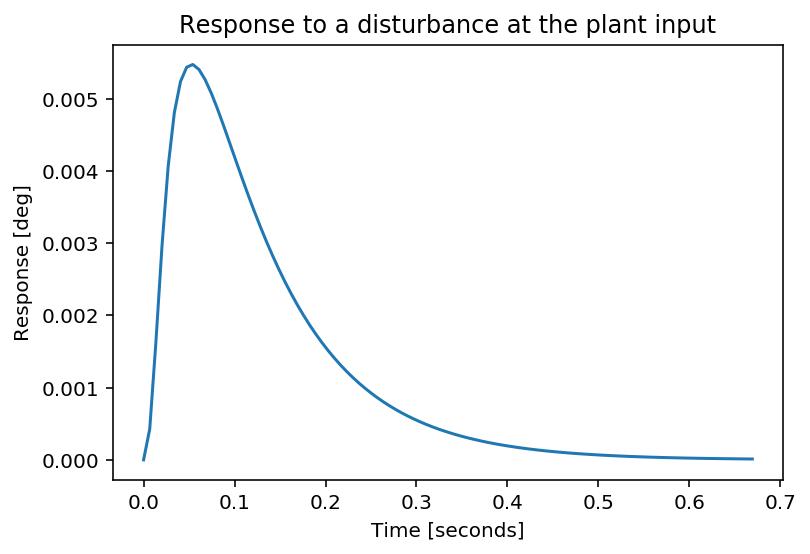

In [27]:
#Error due to Process disturbance at steady state is zero only with an integral term in our controller
t,y = step_response(PS)
plt.plot(t,y)
plt.title('Response to a disturbance at the plant input')
plt.xlabel('Time [seconds]')
plt.ylabel('Response [deg]');

# Effect of encoder quantization

In [28]:
ppr = 1680 #Number of pulses per revolution of encoder

Since the encoder is quadrature, let us say that at any given time, the error in the control effort is 1 tick of the encoder. Then, the total error in number of quadrature ticks is 4 times greater.

In [29]:
error_ticks = 4
error_angle = error_ticks/ppr*360
print("Angular error: {:.4f} deg".format(error_angle))

Angular error: 0.8571 deg


In [30]:
error_ctrlEff = error_angle*Kp
print("Control effort due to angular error: {:d} Vcmd".format(int(error_ctrlEff)))

Control effort due to angular error: 103 Vcmd


Since this control effort acts at high frequency due to noise, the actual control effort may be amplified due to the lead compensator. For such large Vcmd, once the motor begins to move, it has a large inertia which causes it to overshoot and then the Vcmd becomes in the opposite direction. This whole thing repeats and the motor begins to oscillate. If ppr is fixed, then the only way out in such cases is to reduce the loop gain, Kp to more managable values. The reduction in loop gain comes from reduction of cross-over frequency.

**To try by yourself:** (Make modifications to the code and run the cells)
1. As the control effort noise due to encoder quantization will reduce with reducing error angle, increase the ppr of the encoder to say 10,000 and see what happens.
2. Reducing the crossover frequency, $\omega_c$ should reduce Kp and hence also reduce the control effort noise. Try a $\omega_c$ of 10 rad/s.

See how these decisions affect the closed loop response behavior and disturbance rejection (sensitivity). Hence, it is almost always a good idea to reduce encoder quantization, get a larger ppr encoder as possible.

**Design rule:** Select ppr based on target bandwidth ($\omega_n$) such that the error angles due to the disturbance forces and quantization is low enough to give a small disurbance control effort due to the required loop gain, Kp.